### Preparing dataset

In [4]:
variable_labels = {
    'sars_cov2_gc_l_mean': 'SARS-CoV-2 concentration',
    'sample_ph_pre_ansis':'sample pH',
    'ammonia_mg_l':'ammonia concentration',
    'control_gc_l_mean':'control volume',
    'ophosph_mg_l':'phosphate concentration',
    'suspended_solids_mg_l':'suspended solids',
    'sars_below_loq':'below LOQ',
    'sars_below_lod':'below LOD',
    'compo_frac':'composites fraction',
    'reception_delay':'reception delay',
    'catch_cis_population':'covered population',
    'catch_in_cis_prop':'subregion population fraction',
    "catchment_population_ons_mid_2019": "catchment population",
    "catchment_area": 'catchment area'
}

In [5]:
import numpy as np
import pandas as pd
import sklearn 
import scipy
import geopandas as gpd

import datetime
import matplotlib.pylab as plt
import wastewater as ww
from wastewater.ml_utils import Dataset, RandomIntercepts, RandomEffects

# CIS Data
df_cis = ww.load_cis(daily=False).rename(columns={'CIS.name':"CIS20CD"})
df_cis_interpolated = ww.load_cis(daily=True, kind='linear').rename(columns={'CIS.name':"CIS20CD"})

# Preprocess WW data
df_ww = ww.read_ww()
df_ww.to_csv(f'{ww.data_dir}/raw_data_1_dec21.csv')      # example saving to data_dir
df_ww = ww.drop_wrong_dates(df_ww)
df_ww.to_csv(f'{ww.data_dir}/raw_data_2_dec21.csv')      # example saving to data_dir
df_ww = ww.select_specific_sites(df_ww)
df_ww.to_csv(f'{ww.data_dir}/raw_data_3_dec21.csv') # example saving to data_dir
df_ww = ww.select_sites_sampled_before(df_ww, '2021-01-01')
df_ww.to_csv(f'{ww.data_dir}/raw_data_4_dec21.csv') # example saving to data_dir
df_ww =  df_ww.merge(ww.read_sites()[['ww_site_code', 'catchment_population_ons_mid_2019', 'ww_catchment_code']])
df_ww.to_csv(f'{ww.data_dir}/raw_data_5_dec21.csv')
df_ww = df_ww.drop_duplicates(subset=['date_sample_collected', 'ww_site_code'])
df_ww.to_csv(f'{ww.data_dir}/raw_data_6_dec21.csv') 
# it would be preferable here to change the calculation of SARS-CoV-2 gc/l for those without replicate data
df_ww = ww.replace_loq_lod(df_ww, 133, 1333)
df_ww.loc[df_ww.ophosph_mg_l==-3, 'ophosph_mg_l'] = np.nan
df_ww = ww.add_new_ww_features(df_ww, reception_delay=True)
df_ww.to_csv(f'{ww.data_dir}/raw_data_7_dec21.csv') # example saving to data_dir



/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_cis.py:19: UserWarning: Data not yet ingested properly, please change the link to ingested dataset as soon as possible.
  warnings.warn('Data not yet ingested properly, please change the link to ingested dataset as soon as possible.')
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_cis.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_cis = df_cis.drop(df_cis.columns[0], 1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_cis.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_cis = df_cis.drop(['CIS.name', 'RGN19CD'],1).merge(df_cis[['cis_num', 'CIS.name', 'RGN19CD']].drop_duplicates().dropna())


Loading latest flow normalisation file: 20220314_EXPORT_SARS_COV2_FLOW_NORMALISATION.csv
Loading latest anomaly file: 20211018_EXPORT_SARS_COV2_CONCENTRATION_ANOMALY.csv
Missing values (-2 convention) have been replaced by nan
Samples to be rerun (-1 convention) have been replaced by nan
141 samples with wrong or missing dates (date_sample_collected) have been removed.
Selected 311 sites after filter on SEWAGE TREATMENT PLANT (site_type)
Selected 306 sites after filter on UK* codes
Selected 45 sites with first sample before 2021-01-01
LOD ([-4]) and LOQ ([-3, 0]) codes for ['flow_normalised_sars_cov2_gc_l_mean', 'sars_cov2_gc_l_mean'] have been replaced by LOD/2 and LOQ/2 respectively, using default values of LOD=133 and LOQ=1333 where missing in data.


/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/preprocessing.py:476: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  reception_time = pd.to_datetime(df_ww.time_sample_received.astype(str).str.pad(4, fillchar='0'), format='%H%M')- pd.datetime(1900,1,1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/preprocessing.py:477: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  collection_time = pd.to_datetime(df_ww.time_sample_collected.astype(str).str.pad(4, fillchar='0'), format='%H%M')- pd.datetime(1900,1,1)


In [30]:
# check whether replicate data pre-freb 2021 are loaded in
# below doesn't 'quite' get to it, but ~10% samples are with NAs, so that's ok
df_ww.head()
# list(df_ww.columns)
# 'raw_ansis_sars_repc_1',
# 'raw_ansis_sars_repc_2',
print(df_ww['raw_ansis_sars_repc_1'].describe())
nas1 = df_ww['raw_ansis_sars_repc_1'].isna().sum()
nas2 = df_ww['raw_ansis_sars_repc_2'].isna().sum()
rows = len(df_ww)
print(rows)
print('first replicate = ',nas1,' and ', round(100*(nas1/rows),2),'%')
print('second replicate = ',nas2,' and ', round(100*(nas2/rows),2),'%')

count    12745.000000
mean        66.463712
std        214.241247
min         -4.000000
25%         -3.000000
50%          9.036000
75%         41.236988
max       5059.119141
Name: raw_ansis_sars_repc_1, dtype: float64
14351
first replicate =  1606  and  11.19 %
second replicate =  1606  and  11.19 %


In [26]:
# add in year of collection from date
df_ww['year_coll'] = pd.DatetimeIndex(df_ww['date_sample_collected']).year
df_ww['rep1na'] = df_ww['raw_ansis_sars_repc_1'].isna()
df_ww['rep2na'] = df_ww['raw_ansis_sars_repc_2'].isna()
# create a table of observations
#print(df_ww['year_coll'].value_counts())
#print(df_ww['rep1na'].value_counts())
# to have NAs by year of collection I think I need to..
# - create a variable 0/1 of whether replicate is NA or not
# - create a table = df_ww.groupby('year_coll','is_na').size()
table = df_ww.groupby(['year_coll','rep1na']).size()
print(table)

year_coll  rep1na
2020       False     3376
           True       745
2021       False     7755
           True       803
2022       False     1614
           True        58
dtype: int64


In [39]:
# check how the mean value s calculated, and update if it isn't correct.
# raw_ansis_sars_repc_mean
# df_ww['raw_ansis_sars_repc_mean_v2'] = (df_ww['raw_ansis_sars_repc_1'] + df_ww['raw_ansis_sars_repc_2'])/2
# need to select obs where only 1 rep is available, and update
 
def my_repfun (var1,var2,var3):
    df_ww[var3] = np.where((df_ww[var1]<0), df_ww[var2], (df_ww[var1]+df_ww[var2])/2) # if values of var1 <0, use var2 only 
    df_ww[var3] = np.where((df_ww[var2]<0), df_ww[var1], df_ww[var3]) # if values of var2 <0, use var3 only, now that we have made it 
    df_ww[var3] = np.where((df_ww[var1].isna()), df_ww[var2], df_ww[var3]) # if values of var2 <0, use var3 only, now that we have made it 
    df_ww[var3] = np.where((df_ww[var2].isna()), df_ww[var1], df_ww[var3]) # if values of var2 <0, use var3 only, now that we have made it 
    return df_ww

df_ww = my_repfun('raw_ansis_sars_repc_1','raw_ansis_sars_repc_2','raw_ansis_sars_repc_mean_v2')
df_ww['repc_mean_check'] = df_ww['raw_ansis_sars_repc_mean'] - df_ww['raw_ansis_sars_repc_mean_v2']
print(df_ww['repc_mean_check'].describe())
tmp = sum(df_ww['repc_mean_check']!=0)
print('This number of values are incorrectly calculated',tmp,'and percentage',100*(tmp/rows))

# well ... this hasn't been corrected!

count    1.274300e+04
mean    -3.673614e-01
std      1.518420e+00
min     -2.813997e+01
25%     -9.536743e-07
50%      0.000000e+00
75%      0.000000e+00
max      2.845380e+01
Name: repc_mean_check, dtype: float64
This number of values are incorrectly calculated 9237 and percentage 64.36485262351056


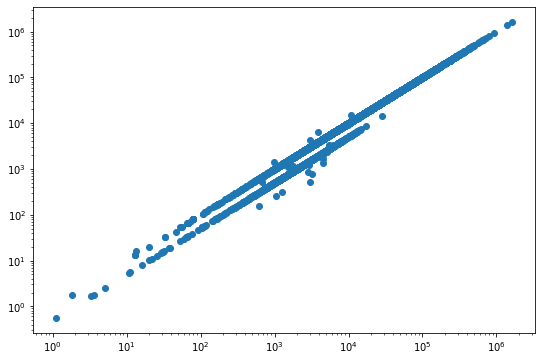

In [45]:
# correct the sars_cov2_gc_l_mean here..
df_ww['sars_c'] = df_ww['sars_cov2_gc_l_mean']/df_ww['raw_ansis_sars_repc_mean']
df_ww['sars_cov2_gc_l_mean_v2'] = df_ww['raw_ansis_sars_repc_mean_v2']*df_ww['sars_c']
# scatter plot

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df_ww['sars_cov2_gc_l_mean_v2'],df_ww['sars_cov2_gc_l_mean'])
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(f'{ww.data_dir}/check_gc_l.png')

In [46]:
# re-define the gc_cl here
df_ww['sars_cov2_gc_l_mean'] = df_ww['sars_cov2_gc_l_mean_v2']  

In [47]:
# add area (function would be good)
gdf_catch = gpd.read_file('s3://dash-879281191186-prod-s3-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_dataset_staging/ww_ons/20201120_ONS_WW_ENGLAND_CATCHMENT_BOUNDARIES.csv')
gdf_catch.set_crs(epsg=27700, inplace=True, allow_override=True)
gdf_catch = gdf_catch.to_crs('epsg:3857')
df_ww = df_ww.merge(gdf_catch.set_index('CATCHMENT_CODE').geometry.area.reset_index().rename(columns={'CATCHMENT_CODE':'ww_catchment_code', 0:'catchment_area'}))
df_ww = df_ww.drop('ww_catchment_code', 1)
df_ww.catchment_area /= 1e6 # in km

df_ww, _ = ww.impute_ww(df_ww)
df_ww  = df_ww.rename(columns={'date_sample_collected': 'date'})
df_ww.to_csv(f'{ww.data_dir}/raw_data_8_dec21.csv') # example saving to data_dir
# df_diagnostic.to_csv(f'{ww.data_dir}/diag_data_8_dec21.csv')


/home/ec2-user/anaconda3/envs/wastewater/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/tmp/ipykernel_26081/4248926751.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ww = df_ww.drop('ww_catchment_code', 1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/preprocessing.py:540: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_diagnostic = pd.concat([diag, diag2, diag3, diag4, diag5], 1)


In [48]:
(df_ww.grab_compo_ind == 'Composite').mean()

0.4900703783708452

In [49]:
threshold = 1 / 1000
df_lookup = ww.load_cis_to_site_lookup()

# select sites whose population is at least 1/1000 of the subregion
df_lookup = df_lookup[df_lookup.catch_in_cis_prop > threshold]  


# Add lookup CIS regions info
df_ww = df_ww.merge(df_lookup[['CIS20CD','ww_site_code', 'catch_in_cis_prop', 'catch_cis_population']] , 
                    on='ww_site_code', how='inner')
df_ww.to_csv(f'{ww.data_dir}/raw_data_9_dec21.csv') #

# getting the populations
subregions_pop = df_lookup.loc[df_lookup.CIS20CD.isin(df_ww.CIS20CD) 
                 & df_lookup.ww_site_code.isin(df_ww.ww_site_code)]\
                 .groupby('CIS20CD')['catch_in_cis_prop','catch_cis_population'].sum().reset_index()


/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_lookups.py:93: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_lookup = df_lookup.drop(['CATCHMENT_CODE', 'CATCHMENT_NAME'], 1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_lookups.py:103: UserWarning: This dataset needs to be ingested properly: jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/ukmidyearestimates20192019ladcodes.xls
  warnings.warn('This dataset needs to be ingested properly: jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/ukmidyearestimates20192019ladcodes.xls')
/tmp/ipykernel_26081/3281686484.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subregions_pop = df_lookup.loc[df_lookup.CIS20CD.isin(df_ww.CIS20CD)


In [5]:
# Export preprocessed WW dataset before aggregating to CIS subregions
# save = True #False
# bucket = "s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/cis_results"
# if save:
#     df_ww.to_csv(bucket+'/df_ww_preprocessed.csv', index=False)

In [50]:
df_ww.ww_site_code.nunique(), len(set(subregions_pop.CIS20CD.unique()).intersection(df_ww.CIS20CD.unique()))

(45, 83)

In [52]:
df_ww.describe()[['raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    'raw_ansis_sars_repc_mean','raw_ansis_sars_repc_std','sars_cov2_gc_l_mean',]].T

,count,mean,std,min,25%,50%,75%,max
raw_ansis_sars_repc_1,38800.0,89.978092,275.183187,-4.000000,2.680000,13.60600,55.298849,5.059119e+03
raw_ansis_sars_repc_2,38800.0,92.556479,302.973243,-4.000000,1.652000,12.15620,54.914001,6.798662e+03
raw_ansis_sars_repc_mean,38800.0,113.620171,388.600951,-4.000000,2.778340,14.35500,63.075001,9.425240e+03
raw_ansis_sars_repc_std,38800.0,-2.544020,1.030282,-3.000000,-3.000000,-3.00000,-3.000000,8.560000e+00
sars_cov2_gc_l_mean,38800.0,24177.217192,52493.655198,-6.623212,1955.199951,7085.31338,22693.250977,1.647030e+06


In [53]:
sample_variables = ['sars_cov2_gc_l_mean', 
                    'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l', 
                    'sample_ph_pre_ansis', 
                    'control_gc_l_mean','reac_vol_control', # "reac_vol_sars", 
                    'raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    'raw_ansis_sars_repc_mean','raw_ansis_sars_repc_std',
                    'compo_frac',
                    'sars_below_lod', 'sars_below_loq', 
                    'reception_delay',
#                    'ww_site_code',  # try here?
#                     'date',
#                   'analysis_lab_code',
                     #'lab_analysis_1.1.1', 'lab_analysis_1.1.2',
                     #'target_gene_N1'
                   ]

site_variables = [
                  'catchment_population_ons_mid_2019',
                  'catchment_area',
                    'site_skey',  # numeric so should be ok.
#                    'ww_site_code',
#                   'water_company_AE',
#                   'water_company_AW', 'water_company_NW', 'water_company_ST',
#                   'water_company_SW', 'water_company_SWS', 'water_company_TW',
#                   'water_company_UU', 'water_company_WW', 'water_company_WXW',
#                   'water_company_YW'
]

cis_variables = ['catch_in_cis_prop', 'catch_cis_population', 'cis_population']

all_variables = sample_variables + site_variables + cis_variables

for var in all_variables:
    if var not in df_ww:
        print(var, 'removed.')
        all_variables.remove(var)

cis_population removed.


In [54]:
'sars_cov2_gc_l_mean', 
'suspended_solids_mg_l', 
'ammonia_mg_l', 
'ophosph_mg_l', 
'sample_ph_pre_ansis', 
'control_gc_l_mean',
'compo_frac',
'sars_below_lod', 'sars_below_loq', 
'reception_delay'
'catchment_population_ons_mid_2019','catchment_area',
'catch_in_cis_prop',  'cis_population'

('catch_in_cis_prop', 'cis_population')

In [55]:
def weighted_agg(variables, weight_column, agg_function):
    def fn(s):
        weights = s[weight_column]
        return pd.Series({ col : np.average(s[col], weights=weights) for col in variables})
    return fn

weighted_avg = weighted_agg(all_variables, 'catch_cis_population', np.nansum)

df_ww_agg = df_ww.groupby(['CIS20CD', 'date']).apply(weighted_avg).reset_index()
df_ww_agg = df_ww_agg.drop(['catch_in_cis_prop','catch_cis_population'], 1).merge(subregions_pop)

/tmp/ipykernel_26081/3114940664.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ww_agg = df_ww_agg.drop(['catch_in_cis_prop','catch_cis_population'], 1).merge(subregions_pop)


In [56]:
# Add cis data
df = df_ww_agg.merge(df_cis_interpolated, how='inner').sort_values(['CIS20CD', 'date'])  # change for left
df = df.dropna(subset=['CIS20CD', 'date'])

df.CIS20CD.nunique()

df_total = df_ww_agg.merge(df_cis_interpolated, how='left').sort_values(['CIS20CD', 'date'])  # change for left
df_total = df_total.dropna(subset=['CIS20CD', 'date'])

In [57]:
df_ww.to_csv(f'{ww.data_dir}/raw_data_10_cis_dec21.csv') #
# 'df' has fewer variables...than 'df_ww'
df.to_csv(f'{ww.data_dir}/raw_data_11_cis_dec21.csv') #
# export_dataset = False
# if export_dataset:
#     df.to_csv(ww.output_dir+'/df_ww_cis.csv', index=False)
#     df.to_csv('s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/df_ww_cis.csv', index=False)

# Models

In [ ]:
from sklearn.linear_model import LinearRegression
from wastewater.ml_utils import RandomIntercepts, RandomEffects
from xgboost import XGBRegressor

dict_models = dict(lr = LinearRegression(),
                   xgb = XGBRegressor(),
                   ri = RandomIntercepts('CIS20CD'),
                   re = RandomEffects('CIS20CD', 
#                                       slope_vars=['sars_cov2_gc_l_mean'], 
                                      correlated_re=False))

model_variables = dict(lr = all_variables,
                       xgb = all_variables,
                       ri =  ['sars_cov2_gc_l_mean', #'control_gc_l_mean', #'reac_vol_control', 
                             'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l', 
                             'sample_ph_pre_ansis', 
                              
                              'compo_frac',
                             'sars_below_lod', 
                              'sars_below_loq'
                             ],
                       re = ['sars_cov2_gc_l_mean', #'control_gc_l_mean', # 'reac_vol_control', 
                             'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l', 
                             'sample_ph_pre_ansis', 
                             'compo_frac',
                             'sars_below_lod', 
                             'sars_below_loq'
                            ]
                      )

# model_variables = dict(lr=['sars_cov2_gc_l_mean'],
#                        xgb=['sars_cov2_gc_l_mean'],
#                        ri=['sars_cov2_gc_l_mean'],
#                        re=['sars_cov2_gc_l_mean'])

model_labels = {'lr': 'Linear Regression', 'ri': 'Random Intercepts', 
                're': 'Random Effects','xgb': 'Gradient Boosted',
               'process': 'Process-based'}

# Predictions

In [ ]:
# Metrics
compute_mae = lambda y, pred: np.abs(pred-y).mean()
compute_mae_natural = lambda y, pred: np.abs(10**pred-10**y).mean()

In [ ]:
# Bootstrap predictions
from wastewater.ml_utils import bootstrap

repeat = 50
preds_bootstrap = {}

models = ['lr', 'ri','re', 'xgb'] # remove some models as desired, as RE can be long for example

for model_name in models: 
    dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 
                      'median_prob', input_offset=0.001)
    x, y = dataset.prepare_no_split()
    preds_bootstrap[model_name] = bootstrap(dict_models[model_name], x, y, repeat=repeat)

In [ ]:
# Computing MEan and SE of errors

dict_pred = {model_name: preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
# dict_pred_natural = {model_name: 10**preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
dict_se = {model_name: pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}
dict_se_natural = {model_name: 10**pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}

import_process = True
if import_process:
    dict_pred['process'] = np.log10(pd.read_csv('s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/df_ww_cis_with_process_estimates_20210617.csv', parse_dates=['date']).set_index(['CIS20CD', 'date']).loc[dict_pred['xgb'].index]['process_based_estimate'])

# Export of scores
save = False
if save:
    bucket = "s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/cis_results"
    
    for model_name in dict_pred:
        dict_pred[model_name].to_csv(bucket+f'/predictions_{model_name}.csv')

In [ ]:
# Printing some metrics for one model
model_name = 'xgb'

# Log space
# print('Log Space')
# print(f'median relative error {np.abs((dict_pred[model_name]-y)/y).median()*100:.4f} %')
# print(f'q95 relative error {np.quantile(np.abs((dict_pred[model_name]-y)/y), 0.95)*100:.4f}')
print(f'mean absolute error {np.abs((dict_pred[model_name]-y)).mean():.4f}')
print(f'median absolute error {np.abs((dict_pred[model_name]-y)).median():.4f}')
print(f'q95 absolute error {np.quantile(np.abs((dict_pred[model_name]-y)), 0.95):.4f}')

# Natural space
print('\nNatural space')
print(f'median relative error {np.abs((10**dict_pred[model_name]-10**y)/10**y).median()*100:.4f}')
print(f'q95 relative error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)/10**y), 0.95)*100:.4f}')

print(f'median absolute error {np.abs((10**dict_pred[model_name]-10**y)).median()*100:.4f}')
print(f'q95 absolute error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)), 0.95)*100:.4f}')

plt.hist((10**dict_pred[model_name]-10**y)/10**y*100, 75, range=(-100, 200))
plt.xlabel('relative error (%)')
plt.show()

plt.hist((10**dict_pred[model_name]-10**y), 50, range=(-3,3))
plt.xlabel('signed error (% infected)')
pass

In [ ]:
# Boxplot comparison for different models

names = [ 'process', 're', 'xgb']
per_subregion = True

dict_err = {name: np.abs((dict_pred[name] -y)) if not per_subregion else np.abs((dict_pred[name] -y)).groupby('CIS20CD').mean() for name in names}
plt.boxplot([dict_err[name] for name in names], 
           )
plt.xticks(range(1, 1+len(names)), labels=[model_labels[name] for name in names])
plt.ylabel(f"MAE {'per subregion' if per_subregion else ''}\n (Log10 % infected)")
plt.show()

dict_err = {name: np.abs((10**dict_pred[name] - 10**y)) if not per_subregion else np.abs((10**dict_pred[name] - 10**y)).groupby('CIS20CD').mean() for name in names}
plt.boxplot([dict_err[name] for name in names], 
           )
plt.xticks(range(1, 1+len(names)), labels=[model_labels[name] for name in names])
plt.ylabel(f"MAE {'per subregion' if per_subregion else ''}\n (% infected)", fontsize=14)
plt.yscale('log')
plt.yticks(fontsize=12)
pass

In [ ]:
# out of period sample
# dict_pred_test = dict()
# start_date_test='2021-01-15'

# for name, model in dict_models.items():
#     dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[name], 
#                   'median_prob', input_offset=0.001)

#     x_train, x_test, y_train, y_test = dataset.temporal_split(start_date_test=start_date_test)
    
#     model.fit(x_train, y_train)
#     dict_pred_test[name] = model.predict(x_test)
#     print(name, f'mae = {compute_mae(y_test, dict_pred_test[name]):.4f}')

In [ ]:
# Cross validation on whole dataset, instead of boostrap
# from wastewater.ml_utils import predict_kfold
# dict_pred = dict()
# for name, model in dict_models.items():
#     dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[name], 
#                       'median_prob', input_offset=0.001)
#     x, y = dataset.prepare_no_split()
#     dict_pred[name] = predict_kfold(model, x, y, 5)
#     print(name, f'mae = {compute_mae(y, dict_pred[name]):.4f}', f'mae_natural = {compute_mae_natural(y, dict_pred[name]):.4f}')

In [ ]:
from wastewater.ml_utils import plot_conditional_pred

for name in dict_models:
    fig, ax = plt.subplots(figsize=(8,6))
    plot_conditional_pred(dataset.y, dict_pred[name], title=model_labels[name], ax=ax)
    ax.set_ylabel(f'Predictions (log10)', fontsize=14)
    ax.set_xlabel('True values (Log10)', fontsize=14)


In [ ]:
# # Error as a function of time

# f, ax = plt.subplots(2, figsize=(12,12), sharex=True)
# ax[1].plot(y.groupby('date').mean().rolling(7).mean(), color='black', label='data')


# for model_name in ['re', 'xgb']:
#     mae_time = (dict_pred[model_name]-dataset.y).groupby('date').agg(lambda x: np.abs(x).mean()).rolling(7).mean()
    
#     ax[0].plot(mae_time, '-o', label=model_labels[model_name])
#     ax[0].set_ylabel('Mean Absolute Error', fontsize=14)
    
    
#     pred_time = dict_pred[model_name].groupby('date').mean().rolling(7).mean()
#     rmse_time = (dict_pred[model_name]-dataset.y).groupby('date').agg(lambda x: (x**2).mean()).rolling(7).mean()
#     ax[1].plot(pred_time, label=f'preds ({model_labels[model_name]})')
#     ax[1].fill_between(pred_time.index,
#                        pred_time - 2 * rmse_time,
#                        pred_time + 2 * rmse_time,
#                        alpha=0.5, label=f'$2 \sigma \simeq 2*RMSE $ ({model_labels[model_name]})'
#                       )
    
#     # Show Interventions :)

#     pass
# ax[0].legend()
# ax[1].legend()
# ax[1].set_ylabel('Log10 CIS pos. rates', fontsize=14)
# ax[1].set_ylim(-1.,1)

##### National average of predictions

In [ ]:
plt.figure(figsize=(12, 5))
model_name = 'xgb'
z = dict_pred[model_name].groupby('date').mean()
z_se = dict_se[model_name].groupby('date').mean()

z_cis = df[['CIS20CD', 'date', 'median_prob', "ll", 'ul']].groupby('date').mean().rolling('7D').mean()


plt.plot(y.groupby('date').mean().rolling('7D').mean(), color='black', label='data')
plt.fill_between(z_cis.index, 
                 np.log10(z_cis.ll), 
                 np.log10(z_cis.ul), alpha=0.3, color='black', label='CIS 95% CI')
plt.plot(z.rolling('7D').mean(),
         color='blue', label=f'mean prediction ({model_labels[model_name]})')
plt.errorbar(z.index, 
             z.rolling('7D').mean(), 
             2*z_se.rolling('7D').mean(),
             color='blue', alpha=0.7, label='Boostrap 95% CI')
plt.ylabel('CIS pos. rates (log10 % infected)', fontsize=14)
plt.legend()

# Natural space
plt.figure(figsize=(12, 5))
model_name = 'xgb'
z = (10**dict_pred[model_name]).groupby('date').mean()
z_se_natural = dict_se_natural[model_name].groupby('date').mean()

plt.plot((10**y).groupby('date').mean().rolling('7D').mean(), color='black', label='data')
plt.fill_between(z_cis.index, 
                 z_cis.ll, 
                 z_cis.ul, alpha=0.3, color='black', label='CIS 95% CI')
plt.plot(z.rolling('7D').mean(),
         color='blue', label=f'mean prediction ({model_labels[model_name]})')
plt.errorbar(z.index, 
             z.rolling('7D').mean(), 
             2*z_se.rolling('7D').mean(),
             color='blue', alpha=0.7, label='Boostrap 95% CI')
plt.ylabel('CIS pos. rates (% infected)', fontsize=14)
plt.legend(loc='upper left')

##### Subregional average of predictions

In [ ]:
model_name = "xgb"

include_ww = True

region_names = ww.read_dataset('LOOKUP_REGISTER_ONS_GEO_CODE').set_index('region_code')[['region_name']].dropna().drop_duplicates()
region_names = region_names.reset_index().rename(columns={'region_code': 'RGN19CD'})

regions = df_cis[['CIS20CD', 'RGN19CD']].drop_duplicates().merge(region_names)
z = dataset.inverse_transform_y(dict_pred[model_name]).reset_index().merge(regions)
z = z.rename(columns={0: 'pred'}).merge(df[['sars_cov2_gc_l_mean', 'catch_cis_population', 'CIS20CD', 'date', 'median_prob', "ll", 'ul']])


se_natural = (dataset.inverse_transform_y(preds_bootstrap[model_name]).std(1) 
              / np.sqrt(repeat - np.isnan(preds_bootstrap[model_name]).sum(1)))
z = z.merge(se_natural.reset_index().rename(columns={0: 'se'}))


regions = ['North West','Yorkshire and The Humber',  'North East', 
           'West Midlands', 'East Midlands', 'East of England', 
           'South West', 'London', 'South East']

fig, axes = plt.subplots(3,3, figsize=(14,9), sharex=True, sharey=True)

for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    group = z[z.region_name == region]
    def fn(x):
        x = x[~np.isnan(x)]
        if not len(x):
            return np.nan
        weights = group.loc[x.index, 'catch_cis_population']
        if np.sum(weights) == 0.:
            weights = np.ones(x.shape)
        return np.average(x, weights=weights)
#     fn = lambda x: x.mean()

    group = group.groupby('date').agg(fn)

    ax.plot(group.median_prob.rolling('7D').mean(), color='black', alpha=0.8, label='CIS median proba')
    ax.fill_between(group.rolling('7D').mean().index, 
                    group.rolling('7D').mean().ll, 
                    group.rolling('7D').mean().ul, alpha=0.3, color='black', label='CIS 95% CI')
    
    ax.plot(group.pred.rolling('7D').mean(), color='blue', lw=2, alpha=0.8, label=f'predictions')
#     ax.plot(group.d.rolling('7D').mean(), color='blue', lw=2, alpha=0.8, label=f'predictions ({model_labels[model_name]})')
    ax.errorbar(group.pred.rolling('7D').mean().index, 
                group.pred.rolling('7D').mean(),
                2*group.se.rolling('7D').mean(),
                color='blue', fmt='none', alpha=0.5, label=f'boostrap 95% CI')
    
    if i%3==0:
        ax.set_ylabel('Prevalence (%)', fontsize=13)
    ax.set_title(region, fontsize=15)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    if  region == "South West":
#         ax.legend(loc='upper left', fontsize=11)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(np.array(handles)[[0, 2, 1, 3]], np.array(labels)[[0, 2, 1, 3]], loc='upper left', fontsize=12)
        
    if include_ww:
        ax2 = ax.twinx()
        ax2.plot(group.sars_cov2_gc_l_mean.rolling('7D').mean(), color='orange', lw=1.1, alpha=0.8, label=f'Wastewater data')
        
        if i%3==2:
            ax2.set_ylabel('SARS-CoV-2 (gc/L)', fontsize=13)
        else:
            ax2.set_yticks([])
        if  region == "South East":
            ax2.legend(loc='upper right', fontsize=12)
    ax2.set_ylim(-10000, 400000)
plt.tight_layout()

In [ ]:
# Dependence of errors with viral load
plt.figure(figsize=(10,6))

for name in ['lr', 're', 'xgb']:
    mean_list = []
    se_list = []
#     plt.scatter(x['sars_cov2_gc_l_mean'], np.abs(dict_pred[name] - y), s=3)

    _, bins = np.histogram(x['sars_cov2_gc_l_mean'], bins=7)
    for i in range(len(bins)-1):
        z = (np.abs(dict_pred[name] - y))[(x['sars_cov2_gc_l_mean']>=bins[i]) & (x['sars_cov2_gc_l_mean']<=bins[i+1])]
        mean_list.append(z.mean())
        se_list.append(z.std()/np.sqrt(len(z)))
    plt.scatter([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)], 
                mean_list)
    plt.errorbar([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)], 
                 mean_list, 2*np.array(se_list), label=model_labels[name])
plt.xlabel('SARS-CoV2 Concentration (gc/L)', fontsize=14)
plt.ylabel('Mean Absolute Error (Log10)', fontsize=14)
plt.legend(fontsize=14)

In [ ]:
#compute sites error
save = False
agg = np.median

# Collect errors per site
list_mae = []
list_mae_natural = []

save = False
for model_name in dict_pred:
    list_mae.append((y - dict_pred[model_name]).groupby('CIS20CD').agg(lambda x: agg(np.abs(x))))
    list_mae[-1].name = model_name
    list_mae_natural.append((10**y - 10**dict_pred[model_name]).groupby('CIS20CD').agg(lambda x:  agg(np.abs(x))))
    list_mae_natural[-1].name = model_name
mae_per_site = pd.concat(list_mae, 1)
mae_natural_per_site = pd.concat(list_mae_natural, 1)

if save:
    mae_per_site.to_csv(ww.output_dir + '/cis_mae_per_site.csv')
# mae_per_site.corr(), mae_per_site.mean(), len(mae_per_site)


# histograms of site errors
# for col in ['process', 're', 'xgb']:
#     plt.hist(mae_per_site[col], label=model_labels[col],
#               alpha=0.5, range=(0, mae_per_site.max().max()), bins=30)
# plt.xlabel('MAE [log10(%)]', fontsize=15)
# plt.legend()

# for col in ['process', 're', 'xgb']:
#     plt.hist(mae_natural_per_site[col], label=model_labels[col], 
#              alpha=0.5, range=(0, mae_natural_per_site.max().max()), bins=30)
# plt.xlabel('Mean Absolute Error (% infected)', fontsize=15)
# plt.legend() 

# for model_name in ['re', 'xgb']:
#     plt.hist((10**dict_pred[model_name]-10**y)/10**y,label=model_labels[model_name], 
#     alpha=0.5, range=(-3, 3), bins=50)
# plt.xlabel('Error [% infected]', fontsize=15)
# plt.legend() 

In [ ]:
# Boxplots for each subregion
f, ax = plt.subplots(figsize=(13,6))
model_name = 're'
mae = np.abs(dict_pred[model_name]-y)
sorted_index = mae.groupby('CIS20CD').median().sort_values(ascending=False).index

pd.DataFrame(mae.unstack(0)[sorted_index]).boxplot(ax=ax)
plt.xticks(rotation=45, fontsize=5)
plt.xlabel('CIS subregions', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=16)
plt.title(f'{model_labels[model_name]}', fontsize=17)
plt.ylim(0, 1)
pass

# Var importance and coefs

##### XGB variable importance

In [ ]:
dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables['xgb'], 'median_prob', 
                              input_offset=0.001)
x, y = dataset.prepare_no_split()
dict_models['xgb'].fit(x, y)
xgb_importance = pd.Series(dict_models['xgb'].feature_importances_, 
                           index=dataset.input_variables).sort_values(ascending=False)

plt.bar(xgb_importance.index, xgb_importance)
plt.xticks(rotation=45, horizontalalignment="right")
pass

##### Coefficients from RE/RI models

In [ ]:
dict_models[model_name].slope_vars = model_variables['re']
model_variables['xgb']

In [ ]:
# # Fixed coef only
# df_coefs = pd.DataFrame(columns=dataset.input_variables)
# for name in ['re', 'ri']:
#     variables = model_variables[name]
#     dict_models[name].fit(x[model_variables['xgb']], y)
#     try:
#         df_coefs = df_coefs.append(pd.Series(dict_models[name].coef_, name=name, index=variables))
#     except AttributeError:
#         pass
#     except KeyError:
#         pass


In [ ]:
# for name in df_coefs.index:
#     df_coefs_t = df_coefs.T.sort_values(name, ascending=False)
#     plt.bar(df_coefs_t.index, df_coefs_t[name], alpha=0.5)
#     plt.xticks(rotation=45, horizontalalignment="right")
#     pass

##### Random effects 

In [ ]:
model_name = 're'

dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 
                      'median_prob', input_offset=0.001)
x, y = dataset.prepare_no_split()

dict_models[model_name].fit(x[model_variables[model_name]], y)



In [ ]:
d = {('Intercept' if var=='Group' else var): [dict_models[model].results_.random_effects[cis][var] 
           for cis in dict_models[model].results_.random_effects] for var in ['Group'] + dataset.input_variables}
variable_labels['Group'] = 'intercept'

data_boxplot = [(np.array([dict_models[model_name].results_.fe_params[k]])
                + np.array(v)) #/dataset.scaler.scale_[i]
                for i, (k,v) in enumerate(d.items())] 

# whether to convert back to original units
# data_boxplot = (data_boxplot * dataset.scaler.scale_[:,np.newaxis])
data_boxplot = np.array(data_boxplot)
plt.boxplot(data_boxplot.T)

for i in range(len(data_boxplot)):
    y = data_boxplot[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.2)
plt.xticks(range(1, 1+len(data_boxplot)), 
           ['Intercept']+[variable_labels[k] for k in dataset.input_variables], 
           rotation=45, horizontalalignment="right")
# plt.hlines(0, 1,  1+len(data_boxplot), color='black', linestyle='')
plt.grid()
plt.ylabel('Random Effect coefficients', fontsize=14)
plt.xlabel('Input variables', fontsize=14)

In [ ]:
df3 = pd.DataFrame(data_boxplot.T, columns=d.keys())
df3['CIS20CD'] = [cis for cis in dict_models[model].results_.random_effects]
df3 = df3.merge(df_cis[['CIS20CD','RGN19CD']].drop_duplicates())

In [ ]:
for col in list(d.keys())[1:]:
    plt.figure(figsize=(9,7))
    for region, group in df3.groupby('RGN19CD'):
        plt.scatter(group.Intercept, group[col], label=region_names.set_index('RGN19CD').loc[region].iloc[0], s=50)
        plt.title(variable_labels[col], fontsize=17)
        plt.ylabel(f'Subregion coefficient', fontsize=15)
        plt.xlabel('Subegion Intercepts', fontsize=15)
    plt.legend()
    plt.show()

##### Partial dependence plots 

In [ ]:
import numpy as np
# This function comes from here: https://github.com/dmlc/xgboost/issues/2035
def partial_dependency(model, X, features, selected_feature):
    # The model could be an XGBoost sklearn fitted instance (or anything else with a 
    # predict method)
    X_temp = X.copy()
    # Works only for numerical features. Find something else for categorical features.
    grid = np.linspace(np.percentile(X_temp.loc[:, selected_feature], 0.1), 
                       np.percentile(X_temp.loc[:, selected_feature], 99.5), 
                       50)
    y_pred = np.zeros(len(grid))
    
    for i, val in enumerate(grid):
        X_temp.loc[:, selected_feature] = val
        y_pred[i] = model.predict(X_temp.loc[:, features]).mean()
    
    return grid, y_pred

In [ ]:
from sklearn.inspection import plot_partial_dependence

model_name = "xgb"

dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 
                      'median_prob', input_offset=0.001)
x, y = dataset.prepare_no_split()
model = dict_models[model_name]
model.fit(x, y)

# f, ax = plt.subplots(figsize=(15,15))
variables_to_plot = ['sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l',
                     'ophosph_mg_l', 'sample_ph_pre_ansis', 'control_gc_l_mean','compo_frac',  'sars_below_loq',
                     'reception_delay', 'catchment_population_ons_mid_2019',
                     'catchment_area', 'catch_in_cis_prop'] #, 'catch_cis_population']

f, axes = plt.subplots(3, 4, figsize=(16,12), sharey=True)

for ax, selected_feature in zip(axes.flatten(), variables_to_plot):
    try:
        grid, out = partial_dependency(model, x, x.columns, selected_feature)
        ax.plot(grid, out)
        ax.set_xlabel(variable_labels[selected_feature], fontsize=15)
        ax.set_ylabel('CIS positivity rates (Log10 %)', fontsize=14)
    except KeyError:
        continue
plt.tight_layout()

# Shifts

In [ ]:
from wastewater.ml_utils import predict_kfold, bootstrap

shifts = range(-10, 20, 1)
repeat= 50

mae_list = {name: [] for name in dict_models}
mae_sem_list ={name: [] for name in dict_models}
mae_natural_list = {name: [] for name in dict_models}
mae_natural_sem_list = {name: [] for name in dict_models}

models = ['lr', 'xgb']

df_ww_2 = df_ww.copy()

# Test of dates consistency
assert df_cis_interpolated.date.min() >= df_ww_2.date.min() + datetime.timedelta(shifts[-1])
assert df_cis_interpolated.date.max() <= df_ww_2.date.max() + datetime.timedelta(shifts[0])

for model_name in models:
    for shift in shifts:
        df_ww_shifted = df_ww.copy()
        df_ww_shifted['date'] += datetime.timedelta(shift)
        df = df_ww_shifted.merge(df_cis_interpolated, how='inner').sort_values(['CIS20CD', 'date'])  # change for left
        df = df.dropna(subset=['CIS20CD', 'date'])
#         df = df[df.date > datetime.datetime(2020,8,1)]
        # Check on the compatibility of dates !


        print(shift, len(df))

        dataset = Dataset(df.set_index(['CIS20CD', 'date']), 
                          model_variables[model_name], 
                          'median_prob', 
                          input_offset=0.001
                         )
        x, y = dataset.prepare_no_split()

        model = sklearn.base.clone(dict_models[model_name])

        pred = predict_kfold(model, x, y)
        bootstrap_pred = bootstrap(dict_models[model_name], x, y, repeat=repeat)
        n_preds = repeat - np.isnan(bootstrap_pred).sum(1)


        mae_list[model_name].append(compute_mae(y, bootstrap_pred.mean(1)))
        mae_sem_list[model_name].append(np.abs(bootstrap_pred - y.values[:,np.newaxis]).mean(0).std() / np.sqrt(repeat))        
        
        mae_natural_list[model_name].append( np.abs(10**y - 10**bootstrap_pred.mean(1)).mean())
        mae_natural_sem_list[model_name].append(np.abs(10**bootstrap_pred - 10**y.values[:,np.newaxis]).mean(0).std() / np.sqrt(repeat))

In [ ]:
window = 1

for model_name in models:
    plt.figure()
    plt.title(model_labels[model_name], fontsize=15)
    plt.plot(shifts, pd.Series(mae_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
             '-o', markersize=6, color='blue', label="mean")
    plt.errorbar(shifts, pd.Series(mae_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
                 2 * np.array(mae_sem_list[model_name]), 
                 markersize=5,  color='blue', label='95% CI')
    plt.ylabel('Mean Absolute Error (log10 space)', fontsize=14)
    plt.xlabel('WW shift (days)', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
for model_name in models:
    plt.figure()
    plt.title(model_labels[model_name], fontsize=15)
    plt.plot(shifts, pd.Series(mae_natural_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
             '-o', markersize=6, color='blue', label="mean")
    plt.errorbar(shifts, pd.Series(mae_natural_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
                 2 * np.array(mae_sem_list[model_name]), 
                 markersize=5,  color='blue', label='95% CI')
    plt.ylabel('Mean Absolute Error (natural)', fontsize=14)
    plt.xlabel('WW shift (days)', fontsize=14)
    plt.legend(fontsize=14)

In [ ]:
bucket = "s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/cis_results"
pd.Series(mae_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_{model_name}.csv", index=False)
pd.Series(mae_sem_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_sem_{model_name}.csv", index=False)
pd.Series(mae_natural_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_natural_{model_name}.csv", index=False)
pd.Series(mae_natural_sem_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_sem_natural_{model_name}.csv", index=False)
pd.Series(shifts).to_csv(bucket+f"/cis_shifts_{model_name}.csv", index=False)

## Ablation tests

In [ ]:
# Choose an evaluation strategy: random samples or latest dates?
evaluation = lambda dataset: dataset.random_split(0.2)  # Random samples evaluation
evaluation = lambda dataset: dataset.temporal_split(start_date_test='2021-02-01')  # out of time range evaluation 

In [ ]:
# Increasing the start week
max_train_date = df_cis_interpolated.date.max()
min_date_0 = df_cis_interpolated.date.min()

n_weeks = ((max_train_date - df_cis_interpolated.date.min())/7).days

mae = {name: [] for name in dict_models}

for model_name in ['xgb', "lr", 're']:
    for week in range(int(n_weeks*0.75)):        
        min_date = min_date_0 + datetime.timedelta(week*7)
        
        dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 'median_prob', 
                          input_offset=0.001)

        x_train, x_test, y_train, y_test = evaluation(dataset)
        x_train_temp = x_train[(x_train.reset_index(1).date>= min_date).values]
        y_train_temp = y_train[(y_train.reset_index(1).date>= min_date).values]
        
        model = sklearn.base.clone(dict_models[model_name])

        model.fit(x_train_temp, y_train_temp)

        pred_test = model.predict(x_test)

        mae[model_name].append(compute_mae(y_test, pred_test))

In [ ]:
for model_name in mae:
    plt.plot(mae[model_name], '-o', label=model_labels[model_name])
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xlabel('start week', fontsize=14)
plt.legend()

In [ ]:
# Decreasing the end week
max_date_0 = df_cis_interpolated.date.max()

n_weeks = ((max_train_date - df_cis_interpolated.date.min())/7).days

mae = {name: [] for name in dict_models}

for model_name in ['xgb', "lr", 're']:
    for week in range(int(n_weeks*0.75)):        
        max_date = max_date_0 - datetime.timedelta(week*7)
        
        dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 'median_prob', 
                          input_offset=0.001)

        x_train, x_test, y_train, y_test = evaluation(dataset)
        x_train_temp = x_train[(x_train.reset_index(1).date<= max_date).values]
        y_train_temp = y_train[(y_train.reset_index(1).date<= max_date).values]
        
        model = sklearn.base.clone(dict_models[model_name])

        model.fit(x_train_temp, y_train_temp)

        pred_test = model.predict(x_test)

        mae[model_name].append(compute_mae(y_test, pred_test))

In [ ]:
for model_name in mae:
    plt.plot(mae[model_name], '-o', label=model_labels[model_name])
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xlabel('Removed weeks (at the end)', fontsize=14)
plt.legend()

In [ ]:
# Randomly exluding training samples

from sklearn.model_selection import train_test_split

max_date_0 = df_cis_interpolated.date.max()

n_weeks = ((max_train_date - df_cis_interpolated.date.min())/7).days

mae = {name: [] for name in dict_models}

test_sizes = np.linspace(0.1, 0.9, 10)

for model_name in ['xgb', "lr", 're']:
    for test_size in test_sizes:       
        max_date = max_date_0 - datetime.timedelta(week*7)
        
        dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 'median_prob', 
                          input_offset=0.001)

        x_train, x_test, y_train, y_test = evaluation(dataset)
        
        x_train_temp, _, y_train_temp, _ = train_test_split(x_train, y_train, random_state=0, test_size=test_size)
        
        model = sklearn.base.clone(dict_models[model_name])

        model.fit(x_train_temp, y_train_temp)

        pred_test = model.predict(x_test)

        mae[model_name].append(compute_mae(y_test, pred_test))

In [ ]:
for model_name in ['xgb', "lr", 're']:
    plt.plot(test_sizes*100, mae[model_name], '-o', label=model_labels[model_name])
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xlabel('removed train samples (%)', fontsize=14)
plt.legend()

In [ ]:
# Randomly exluding training sites

from sklearn.model_selection import train_test_split

max_date_0 = df_cis_interpolated.date.max()

n_weeks = ((max_train_date - df_cis_interpolated.date.min())/7).days

mae = {name: [] for name in dict_models}

n_removed_sites = np.arange(0, int(len(df.CIS20CD.unique())*0.75), 5)

for model_name in ['xgb', "lr", 're']:
    for i in n_removed_sites:
            subregions = np.random.choice(df.CIS20CD.unique(), size=len(df.CIS20CD.unique()) - i, replace=False)
            dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 'median_prob', 
                              input_offset=0.001)
            x_train, x_test, y_train, y_test = evaluation(dataset)

            x_train_temp = x_train.loc[subregions]
            y_train_temp = y_train.loc[subregions]

            model = sklearn.base.clone(dict_models[model_name])

            model.fit(x_train_temp, y_train_temp)

            pred_test = model.predict(x_test)

            mae[model_name].append(compute_mae(y_test, pred_test))
        

In [ ]:
for model_name in ['xgb', "lr", 're']:
    plt.plot(n_removed_sites/len(df.CIS20CD.unique())*100, mae[model_name], '-o', label=model_labels[model_name])
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xlabel('removed subregions (%)', fontsize=14)
plt.legend()

# CIS stochastic sampling

- CIS is skewed, Q975 alwawys further from median than Q025
- pos rates always positive by definition

--> log-normal sensible choice

In [ ]:
plt.hist((df_cis.ul - df_cis.median_prob) / (df_cis.median_prob - df_cis.ll), 50)
plt.title('Ratio of (Q975 - Median)/(Median - Q025)', fontsize=17)
pass

In [ ]:
def compute_lognormal_params_from_cis(df_cis):
    # mu 
    mu = np.log(df_cis.median_prob)

    # sigma
    p = 0.025
    sigma = (1  / np.sqrt(2)) * (np.log(df_cis.ll) - mu) / scipy.special.erfinv(2*p-1)

    return mu, sigma

def sample_from_cis(df_cis, size=None):
    mu, sigma = compute_lognormal_params_from_cis(df_cis)
    return np.random.lognormal(mu, sigma, size=size)


In [ ]:
mu, sigma = compute_lognormal_params_from_cis(df_cis)

q975 = np.exp(mu + np.sqrt(2)*sigma*scipy.special.erfinv(2*0.975-1))

plt.hist((q975 - df_cis.ul)/df_cis.ul*100, 50)
plt.title('relative error in q975',fontsize= 17)
plt.xlabel('%', fontsize=15)
pass

#### This confirms that lognormal is OK

In [ ]:
plt.hist(sample_from_cis(df_cis), 100)
pass

In [ ]:
# looking at distribution
n_samples=5000
i = 5
h, b, _ = plt.hist([sample_from_cis(df_cis.iloc[i]) for _ in range(n_samples)], 50)
plt.vlines(df_cis.median_prob[i], 0, np.max(h), color='green', label='median', lw=5)
plt.vlines(df_cis.ll[i], 0, np.max(h), color='red', label='LL')
plt.vlines(df_cis.ul[i], 0, np.max(h), color='purple', label='UL')
plt.legend()

In [ ]:
def dataset_sampled_from_cis(df_cis_interpolated, df_ww_agg, *args, **kwargs):
    df_cis_interpolated_temp = df_cis_interpolated.copy()
    df_cis_interpolated_temp['sample'] = np.nan
    
    df_cis_interpolated_temp['sample'] = sample_from_cis(df_cis_interpolated)
    df_temp = df_ww_agg.merge(df_cis_interpolated_temp, how='inner').sort_values(['CIS20CD', 'date'])  # change for left
    df_temp = df_temp.dropna(subset=['CIS20CD', 'date'])
    return Dataset(df_temp.set_index(['CIS20CD', 'date']), *args, **kwargs)


In [ ]:
# fitting model for 10 samples
n_samples = 10

samples = {name: [] for name in dict_models}
preds = {name: [] for name in dict_models}

for model_name in ['xgb', 're']:
    for i in range(n_samples):
        dataset = dataset_sampled_from_cis(df_cis_interpolated, df_ww_agg, 
                                           model_variables[model_name], 
                                           'sample', 
                                           input_offset=0.001
                                          )
        x, y = dataset.prepare_no_split()

        model = sklearn.base.clone(dict_models[model_name])

        samples[model_name].append(y)
        preds[model_name].append(predict_kfold(model, x, y))

In [ ]:
for model_name in ['xgb', 're']:
    mean_samples =  np.array(samples[model_name]).mean(0)
    sem_samples = np.array(samples[model_name]).std(0) / np.sqrt(n_samples)

    mean_preds =  np.array(preds[model_name]).mean(0)
    sem_preds = np.array(preds[model_name]).std(0) / np.sqrt(n_samples)

    plt.figure(figsize=(12,7))
    plt.errorbar(y, mean_preds, xerr=sem_samples, yerr=2*sem_preds,fmt='o', markersize=1, label='$2\sigma_{mean}$', alpha=0.7)
    plt.ylabel('Predicted Log CIS positivity rate', fontsize=15)
    plt.xlabel('Sampled Log CIS positivity rate', fontsize=15)
    plt.title(f'Predictions from {model_labels[model_name]}', fontsize=16)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')
    plt.ylim(-1.5, 1.)
    plt.legend(fontsize=15)

In [ ]:
plt.hist(sem_preds, 50)
plt.title(f'Std. err. mean preds. when sampling target according to CIS distribution ({n_samples} repeats)', fontsize=14)
plt.xlabel('$\sigma_{CIS}$', fontsize=14)

In [ ]:
plt.boxplot([np.nanmean(np.abs(np.array(preds[model_name]) - np.array(samples[model_name])), 1) 
             for model_name in ['re', 'xgb']])
plt.ylabel('Mean Absolute Error', fontsize=15)
plt.xticks(range(1, 3), [model_labels[name] for name in ['re', 'xgb']], rotation=0, fontsize=15)
plt.title('Prediction-error when sampling in CIS Conf. Int.', fontsize=15)

# Quantile prediction from gradient boosted
- use example here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
- potential issue when using xgb so using only classic gradient boosted algo below :'(

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor

# # Quantile loss XGB
# alpha = 0.05
# gbm = GradientBoostingRegressor()
# gbm_lower = GradientBoostingRegressor(loss="quantile", alpha=alpha)
# gbm_upper = GradientBoostingRegressor(loss="quantile", alpha=1-alpha)

# pred = predict_kfold(gbm, x, y)
# pred_lower = predict_kfold(gbm_lower, x, y)
# pred_upper = predict_kfold(gbm_upper, x, y)

# assert (pred_lower < pred).mean() and (pred_upper > pred)

# plt.figure(figsize=(11, 5))

# plt.scatter(pred, pred_upper, s=1, label=f'lower quantile ($\\alpha=${alpha})')
# plt.scatter(pred, pred_lower, s=1, label=f'upper quantile ($\\alpha=${1-alpha})')
# plt.plot([pred.min(), pred.max()], [pred.min(), pred.max()], color='red')
# plt.legend()
# plt.show()

# plt.figure(figsize=(14,8))
# plt.errorbar(y, pred, 
#              [pred-pred_lower, pred_upper-pred], fmt='o', alpha=0.1)
# plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')


### Bootstrapping and evaluating out of training sample

In [ ]:
model_name = 'xgb'

preds_bootstrap = {}
preds_bootstrap_eval = {}

dataset = Dataset(df_total.set_index(['CIS20CD', 'date']), model_variables[model_name], 
          'median_prob', input_offset=0.001)

x_train, x_eval, y_train, _ = dataset.temporal_split(start_date_test = df_cis_interpolated.date.max()  + datetime.timedelta(1))
y_train = y_train.dropna()
x_train = x_train.loc[y_train.index]
preds_bootstrap[model_name], preds_bootstrap_eval[model_name] = bootstrap(dict_models[model_name], 
                                                                          x_train, y_train, x_eval=x_eval, repeat=50)

In [ ]:
plt.figure(figsize=(12, 5))
z = preds_bootstrap[model_name].mean(1).groupby('date').mean().rolling('7D').mean()
zerror = (2*preds_bootstrap[model_name].std(1)/np.sqrt(n_preds)).groupby('date').apply(lambda x:np.sqrt((x**2).mean()))

z_eval = preds_bootstrap_eval[model_name].mean(1).groupby('date').mean().rolling('7D').mean()
z_eval_error = (2*preds_bootstrap_eval[model_name].std(1)/np.sqrt(repeat)).groupby('date').apply(lambda x:np.sqrt((x**2).mean()))


plt.plot(y.groupby('date').mean().rolling('7D').mean(), color='black', label='data')
plt.plot(z.index, z, color='blue', label=f'mean prediction ({model_labels[model_name]})')
plt.errorbar(z.index, z, 
             zerror.rolling('7D').mean(),
             color='blue', alpha=0.7, label='Boostrap 95% CI')

# plt.plot(z_eval.index, z_eval, color='blue') #, label=f'mean prediction ({model_labels[model_name]})')
# plt.errorbar(z_eval.index, z_eval, 
#              z_eval_error.rolling('7D').mean(),
#              color='blue', alpha=0.7)

plt.ylabel('CIS % infected (log10)', fontsize=14)
plt.legend()

## Data figures for article

In [ ]:
x, y = Dataset(df.set_index(['CIS20CD', 'date']), all_variables, 'median_prob', input_offset=0.001).prepare_no_split()

In [ ]:
variables = all_variables
variables.remove('reac_vol_control')

plt.figure(figsize=(7,7))
plt.imshow(x[variables].corr(), cmap='coolwarm', vmin=-1.)
locs, labels=plt.xticks()
plt.xticks(range(len(x[variables].columns)), 
           [(variable_labels[l] if l in variable_labels else l) for l in x[variables].columns],
           rotation=45, horizontalalignment='right', fontsize=12)
plt.yticks(range(len(x[variables].columns)), 
           [(variable_labels[l] if l in variable_labels else l) for l in x[variables].columns],
           horizontalalignment='right', fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f'Pearson Correlation', fontsize=15, rotation=270, labelpad=20)
pass

#### PCA decomposition

In [ ]:
from sklearn.decomposition import PCA
variables = sample_variables

pca = PCA(n_components=len(x[variables].columns))
pca.fit(x[variables])
plt.plot(range(1, len(variables)+1), np.cumsum(pca.explained_variance_ratio_)*100, '--o', markersize=8)
plt.ylabel('explained variance (%)', fontsize=14)
plt.xlabel('components', fontsize=14)

In [ ]:
# Looking at some nationally averaged variables
for col in ['sars_cov2_gc_l_mean', 'ammonia_mg_l', 'control_gc_l_mean', 'sample_ph_pre_ansis', "sars_below_loq", 'sars_below_lod', 'target_gene_N1']:
    plt.figure(figsize=(12, 5))
    plt.plot(df_ww.groupby('date').mean().rolling('7D').mean()[col], label=col)
    plt.xlim(datetime.datetime(2020, 8, 15))
#     plt.ylabel('SARS-CoV2 Concentration Log10(gc/L)', fontsize=13)
    plt.ylabel('Log10', fontsize=14)
    plt.legend()